In [1]:
import torch
i = torch.LongTensor([[0,1,1], [2,0,2]])
v = torch.FloatTensor([3,4,5])
torch.sparse.FloatTensor(i,v, torch.Size([2,3])).to_dense()

/tmp/ipykernel_28637/1417085159.py:4: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  torch.sparse.FloatTensor(i,v, torch.Size([2,3])).to_dense()


tensor([[0., 0., 3.],
        [4., 0., 5.]])

In [2]:
from src.modeling._smpl import SMPL, Mesh
smpl = SMPL().to(torch.device('cuda'))
mesh_sampler = Mesh()

/home/juno/MambaHMR/src/modeling/_smpl.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  i = torch.LongTensor([row, col])
/home/juno/anaconda3/envs/hgcn/lib/python3.9/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [3]:
coord_gt = smpl.v_template.unsqueeze(dim=0)

In [4]:
coord_gt.shape

torch.Size([1, 6890, 3])

In [5]:
face = smpl.faces
print(face)

tensor([[   1,    2,    0],
        [   0,    2,    3],
        [   2,    1,    4],
        ...,
        [4805, 3511, 6309],
        [3511, 1330, 6309],
        [6309, 1330, 4687]], device='cuda:0')


In [6]:
df1 = coord_gt.shape

In [7]:
def get_EdgeLengthLoss(coord_out, coord_gt, face):
    # face = torch.LongTensor(face).cuda()

    d1_out = torch.sqrt(
        torch.sum((coord_out[:, face[:, 0], :] - coord_out[:, face[:, 1], :]) ** 2, 2, keepdim=True))
    d2_out = torch.sqrt(
        torch.sum((coord_out[:, face[:, 0], :] - coord_out[:, face[:, 2], :]) ** 2, 2, keepdim=True))
    d3_out = torch.sqrt(
        torch.sum((coord_out[:, face[:, 1], :] - coord_out[:, face[:, 2], :]) ** 2, 2, keepdim=True))

    d1_gt = torch.sqrt(torch.sum((coord_gt[:, face[:, 0], :] - coord_gt[:, face[:, 1], :]) ** 2, 2, keepdim=True))
    d2_gt = torch.sqrt(torch.sum((coord_gt[:, face[:, 0], :] - coord_gt[:, face[:, 2], :]) ** 2, 2, keepdim=True))
    d3_gt = torch.sqrt(torch.sum((coord_gt[:, face[:, 1], :] - coord_gt[:, face[:, 2], :]) ** 2, 2, keepdim=True))

    diff1 = torch.abs(d1_out - d1_gt)
    diff2 = torch.abs(d2_out - d2_gt)
    diff3 = torch.abs(d3_out - d3_gt)
    loss = torch.cat((diff1, diff2, diff3), 1)
    return loss.mean()

In [8]:
weight = smpl.weights
# 創建一個空列表，用於存儲結果
indices_lists = [[] for _ in range(weight.shape[1])]

# 使用列表推導來填充每個列表
for joint_idx in range(weight.shape[1]):
    indices_lists[joint_idx] = (weight[:, joint_idx] > 0.4).nonzero().squeeze().tolist()

# 打印結果
for i, indices_list in enumerate(indices_lists):
    print(f"Joint {i} indices with weight > 0.4: {indices_list}")

Joint 0 indices with weight > 0.4: [631, 632, 654, 657, 662, 665, 676, 677, 678, 679, 705, 720, 796, 799, 800, 801, 802, 807, 808, 809, 810, 815, 816, 822, 823, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 912, 914, 915, 916, 917, 918, 919, 920, 932, 937, 938, 939, 1203, 1204, 1205, 1206, 1207, 1208, 1246, 1247, 1276, 1336, 1337, 1338, 1339, 1446, 1447, 1448, 1449, 1450, 1454, 1497, 1511, 1512, 1513, 1540, 1768, 1769, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 3021, 3022, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095,

In [9]:
weight = smpl.weights
print(weight.shape)
sub_weight = mesh_sampler.downsample(weight, n1=0, n2=2)
print(sub_weight.shape)

torch.Size([6890, 24])
torch.Size([431, 24])


In [10]:
import pandas as pd
blend_w_np = sub_weight.cpu().detach().numpy()
df = pd.DataFrame(blend_w_np)
df.to_csv('blend_weights.csv', index=False)

In [11]:
# 創建一個空列表，用於存儲結果
indices_lists = [[] for _ in range(sub_weight.shape[1])]

# 使用列表推導來填充每個列表
for joint_idx in range(sub_weight.shape[1]):
    indices_lists[joint_idx] = (sub_weight[:, joint_idx] > 0.33).nonzero().squeeze().tolist()

sum = 0 
# 打印結果
for i, indices_list in enumerate(indices_lists):
    print(f"Joint {i} indices with weight > 0.4: {indices_list}")
    sum += len(indices_list)
print("total number : ",sum)

Joint 0 indices with weight > 0.4: [45, 52, 53, 55, 56, 58, 59, 61, 62, 63, 67, 69, 100, 103, 106, 118, 134, 135, 175, 182, 183, 188, 189, 190, 191, 192, 193, 266, 272, 273, 274, 276, 277, 280, 284, 312, 314, 344, 345, 346, 386, 387, 394, 395, 396, 397, 398, 399]
Joint 1 indices with weight > 0.4: [57, 60, 61, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 90, 93, 96, 97, 100, 103, 108, 109, 116, 117, 194, 195]
Joint 2 indices with weight > 0.4: [96, 109, 275, 276, 279, 280, 283, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 308, 309, 310, 311, 312, 314, 325, 326, 327, 329, 399]
Joint 3 indices with weight > 0.4: [45, 52, 53, 63, 69, 95, 106, 171, 172, 182, 183, 184, 266, 272, 273, 281, 284, 385, 387]
Joint 4 indices with weight > 0.4: [74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 94, 115, 197, 198, 199, 200, 201, 211, 212, 227, 228, 229]
Joint 5 indices with weight > 0.4: [292, 293, 294, 295, 297, 298, 299, 300, 301, 302, 303, 304, 30

In [12]:
import dhg
from dhg.structure import Hypergraph

/home/juno/anaconda3/envs/hgcn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
num_v=431
hg = Hypergraph(num_v, indices_lists)

In [14]:
hg.e[0]

[(45,
  52,
  53,
  55,
  56,
  58,
  59,
  61,
  62,
  63,
  67,
  69,
  100,
  103,
  106,
  118,
  134,
  135,
  175,
  182,
  183,
  188,
  189,
  190,
  191,
  192,
  193,
  266,
  272,
  273,
  274,
  276,
  277,
  280,
  284,
  312,
  314,
  344,
  345,
  346,
  386,
  387,
  394,
  395,
  396,
  397,
  398,
  399),
 (57,
  60,
  61,
  64,
  65,
  66,
  67,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  90,
  93,
  96,
  97,
  100,
  103,
  108,
  109,
  116,
  117,
  194,
  195),
 (96,
  109,
  275,
  276,
  279,
  280,
  283,
  286,
  287,
  288,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  297,
  298,
  308,
  309,
  310,
  311,
  312,
  314,
  325,
  326,
  327,
  329,
  399),
 (45,
  52,
  53,
  63,
  69,
  95,
  106,
  171,
  172,
  182,
  183,
  184,
  266,
  272,
  273,
  281,
  284,
  385,
  387),
 (74,
  75,
  76,
  77,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  91,
  92,
  94,
  115,
  197,
  198,
  199,
  200,
  20

In [15]:
from itertools import chain
import numpy as np
e_list = indices_lists
v_idx = list(chain(* e_list))
e_idx = [[idx] * len(e) for idx, e in enumerate(e_list)]
e_idx = list(chain(*e_idx))
print(len(e_idx))
H = np.zeros((num_v, len(e_list)))
print(len(v_idx))

537
537


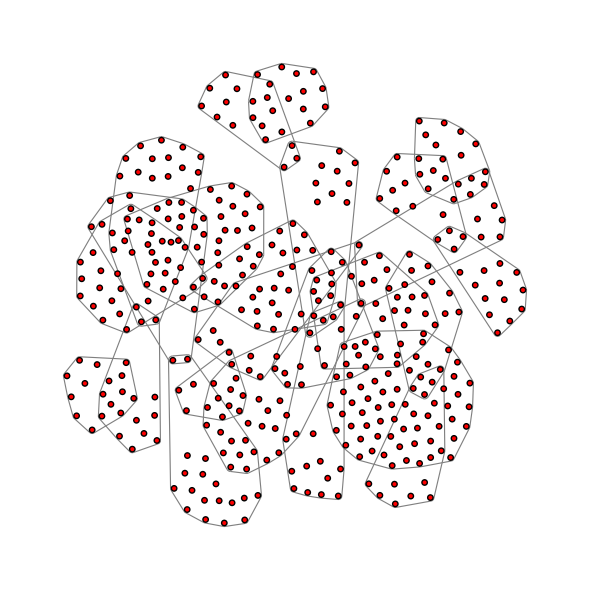

In [16]:
hg.draw()

In [17]:
hg.save("mesh_33_hg.pkl")

In [18]:
index_list = [torch.tensor(sublist).long().to(torch.device('cuda')) for sublist in e_list]

In [19]:
# 提取各 part 頂點的座標
# part = [smpl.v_template.index_select(0, sub_index) for sub_index in index_list]
# part = [smpl.v_template.index_select(0, sub_index) for sub_index in index_list]
# smpl.v_template.shape[indices1]

In [20]:
def visualize_reconstruction_no_text(img, img_size, vertices, camera, renderer, color='pink', focal_length=1000):
    """Overlays gt_kp and pred_kp on img.
    Draws vert with text.
    Renderer is an instance of SMPLRenderer.
    """
    # Fix a flength so i can render this with persp correct scale
    res = img.shape[1]
    camera_t = np.array([camera[1], camera[2], 2*focal_length/(res * camera[0] +1e-9)])
    rend_img = renderer.render(vertices, camera_t=camera_t,
                               img=img, use_bg=True,
                               focal_length=focal_length,
                               body_color=color)
    # rend_img = renderer.render_vertex_color(vertices, camera_t=camera_t,
    #                                            img=img, use_bg=False,
    #                                            focal_length=focal_length,
                                               # )
    
    # combined = np.hstack([img, rend_img])

    return rend_img

In [21]:
def visualize_mesh( renderer, images,
                    pred_vertices_full,
                    pred_camera):
    img = images.cpu().numpy().transpose(1,2,0)
    # Get predict vertices for the particular example
    vertices_full = pred_vertices_full.cpu().numpy() 
    cam = pred_camera.cpu().numpy()
    # Visualize only mesh reconstruction 
    rend_img = visualize_reconstruction_no_text(img, 224, vertices_full, cam, renderer, color='light_blue')
    rend_img = rend_img.transpose(2,0,1)
    return rend_img

In [22]:
from torchvision import transforms
transform = transforms.Compose([           
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])

transform_visualize = transforms.Compose([           
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor()])

In [47]:
template_pose = torch.zeros((1,72))
template_pose[:,0] = 3.1416 # Rectify "upside down" reference mesh in global coord
template_pose = template_pose.cuda()
template_betas = torch.zeros((1,10)).cuda()
template_vertices = smpl(template_pose, template_betas)

In [51]:
template_vertices.squeeze().shape

torch.Size([6890, 3])

In [50]:
smpl.v_template.shape

torch.Size([6890, 3])

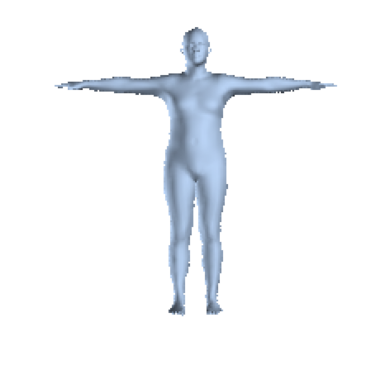

In [57]:
from PIL import Image
from src.utils.renderer import Renderer
import cv2
import matplotlib
# matplotlib.use('qt5agg')
import matplotlib.pyplot as plt

renderer = Renderer(faces=smpl.faces.cpu().numpy())
smpl.eval()
image_file = "./samples/0001.jpg"
with torch.no_grad():
    image = torch.ones(3, 448, 448)
    # img = Image.open(image_file)
    # pred_camera = torch.tensor([[0.9700, -0.0087, -0.1295]])
    pred_camera = torch.tensor([[0.9, 0, 0]])
    img = transforms.ToPILImage()(image)
    img_tensor = transform(img)
    img_visual = transform_visualize(img)

    batch_imgs = torch.unsqueeze(img_tensor, 0).cuda()
    batch_visual_imgs = torch.unsqueeze(img_visual, 0).cuda()
    visual_imgs_output = visualize_mesh(renderer, batch_visual_imgs[0],
                                                    template_vertices.squeeze(),
                                                    pred_camera.squeeze(0).detach())
    
    visual_imgs = visual_imgs_output.transpose(1, 2, 0)
    # visual_imgs = np.asarray(visual_imgs)
    image_np = np.round(np.asarray(visual_imgs*255)).astype(np.uint8)
    plt.imshow(image_np)
    plt.axis('off')  # 关闭坐标轴
    plt.show()

In [24]:
from src.utils.geometric_layers import orthographic_projection
pred_2d_joints_from_smpl = orthographic_projection(smpl.v_template.detach().unsqueeze(0)*(-1), pred_camera.to(torch.device("cuda")))

In [25]:
2d_sub_smpl = orthographic_projection(smpl.v_template.detach().unsqueeze(0)*(-1), pred_camera.to(torch.device("cuda")))

SyntaxError: invalid syntax (1089582385.py, line 1)

In [26]:
sub_mesh = mesh_sampler.downsample(smpl.v_template)
sub2_mesh = mesh_sampler.downsample(smpl.v_template, n1=0, n2=2)
print(sub2_mesh.shape)
print(sub_mesh.shape)

torch.Size([431, 3])
torch.Size([1723, 3])


In [27]:
full_2d_mesh = orthographic_projection(smpl.v_template.unsqueeze(0)*(-1), pred_camera.to(torch.device("cuda"))).squeeze()
sub_2d_mesh = orthographic_projection(sub_mesh.unsqueeze(0)*(-1), pred_camera.to(torch.device("cuda"))).squeeze()
sub2_2d_mesh = orthographic_projection(sub2_mesh.unsqueeze(0)*(-1), pred_camera.to(torch.device("cuda"))).squeeze()

In [28]:
print(full_2d_mesh.shape)
print(sub_2d_mesh.shape)
print(sub2_2d_mesh.shape)

torch.Size([6890, 2])
torch.Size([1723, 2])
torch.Size([431, 2])


In [29]:
def draw_vetices(background, vertices_2d, color, r = 1):
    image = background.copy() 
    vertices_norm = ((vertices_2d + 1) * 0.5) * image.shape[1]
    for jj in range(vertices_2d.shape[0]):
        x = int(vertices_norm[jj,0])
        y = int(vertices_norm[jj,1])
        # cv2.putText(image , str(jj), (x+5,y+5), cv2.FONT_HERSHEY_PLAIN,  1, color, 1, cv2.LINE_AA)
        cv2.circle(image,(x,y), r, color, -1) 
    return image

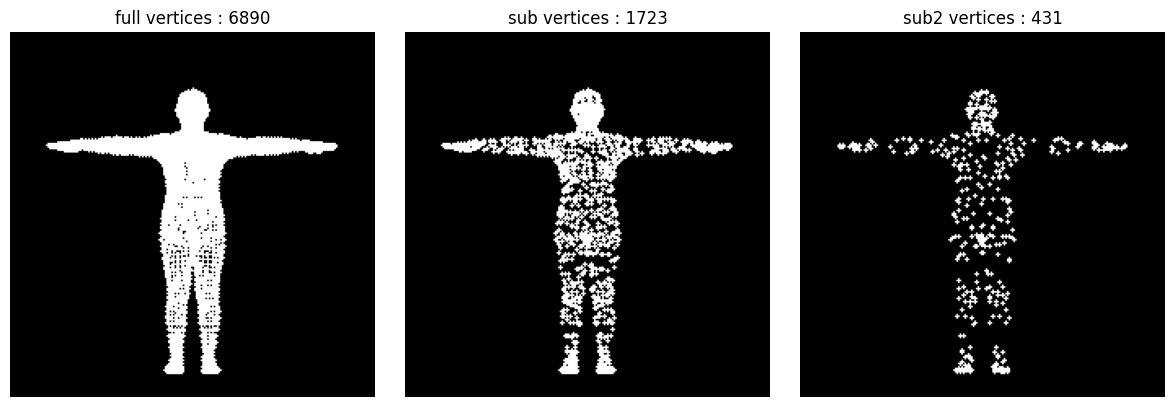

In [30]:
height, width = 224, 224
background = np.zeros((height, width, 3), dtype=np.uint8)
color = (255,255,255)
image1 = draw_vetices(background, full_2d_mesh, color)
image2 = draw_vetices(background, sub_2d_mesh, color)
image3 = draw_vetices(background, sub2_2d_mesh, color)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# 在每个子图上显示一个图像
axs[0].imshow(image1)
axs[0].axis('off')  # 关闭坐标轴
axs[0].set_title('full vertices : 6890')

axs[1].imshow(image2)
axs[1].axis('off')
axs[1].set_title('sub vertices : 1723')

axs[2].imshow(image3)
axs[2].axis('off')
axs[2].set_title('sub2 vertices : 431')

# 显示画布
plt.tight_layout()  # 调整子图布局，防止重叠
plt.show()

In [31]:
colors = [
    (255, 0, 0),    # 红色
    (0, 255, 0),    # 绿色
    (0, 0, 255),    # 蓝色
    (255, 255, 0),  # 黄色
    (255, 0, 255),  # 洋红色
    (0, 255, 255),  # 青色
    (128, 0, 0),    # 深红色
    (0, 128, 0),    # 深绿色
    (0, 0, 128),    # 深蓝色
    (128, 128, 0),  # 橄榄色
    (128, 0, 128),  # 紫色
    (0, 128, 128),  # 珊瑚色
    (255, 128, 0),  # 橙色
    (255, 0, 128),  # 粉红色
    (128, 255, 0),  # 浅绿色
    (0, 255, 128),  # 薄荷绿
    (128, 0, 255),  # 浅紫色
    (0, 128, 255),  # 天蓝色
    (255, 128, 128),# 桃红色
    (128, 255, 128),# 浅紫罗兰
    (128, 128, 255),# 淡天蓝
    (255, 255, 128),# 淡黄
    (128, 255, 255),# 淡青
    (255, 128, 255) # 淡粉
]

In [32]:
part = [sub2_2d_mesh.index_select(0, sub_index) for sub_index in index_list]

In [33]:
smpl.v_template.unsqueeze(0).shape

torch.Size([1, 6890, 3])

In [34]:
J24_TO_J14 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 18]
H36M_J17_TO_J14 = [3, 2, 1, 4, 5, 6, 16, 15, 14, 11, 12, 13, 8, 10]
h36m_joint = smpl.get_h36m_joints(smpl.v_template.unsqueeze(0))
J24_joint = smpl.get_joints(smpl.v_template.unsqueeze(0))
J24_14_joint = J24_joint[:, J24_TO_J14,:]
print(h36m_joint.shape)
J14_joint = h36m_joint[:,H36M_J17_TO_J14,:]
print(J24_joint.shape)
print(J14_joint.shape)
pred_camera = torch.tensor([[0.9, 0, -0.2]])
J24_2d_joint = orthographic_projection(J24_joint*(-1), pred_camera.to(torch.device("cuda"))).squeeze()
h36m_2d_joint = orthographic_projection(h36m_joint.contiguous()*(-1), pred_camera.to(torch.device("cuda"))).squeeze()
J14_2d_joint = orthographic_projection(J14_joint*(-1), pred_camera.to(torch.device("cuda"))).squeeze()
J24_14_2d_joint = orthographic_projection(J24_14_joint*(-1), pred_camera.to(torch.device("cuda"))).squeeze()

torch.Size([1, 17, 3])
torch.Size([1, 24, 3])
torch.Size([1, 14, 3])


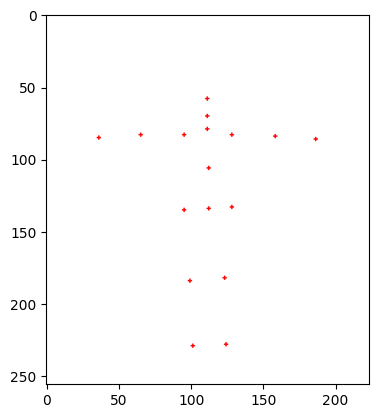

In [35]:
height, width = 256, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_bd = bg
alpha = 0.35  
out_img = draw_vetices(image_bd, h36m_joint[0]*(-1), colors[0])
plt.imshow(out_img)

tensor([[ 8.2784e-02,  8.0535e-01],
        [ 9.6980e-02,  4.4678e-01],
        [ 1.2386e-01,  1.0578e-03],
        [-1.2051e-01,  1.2017e-03],
        [-9.1801e-02,  4.4094e-01],
        [-7.9565e-02,  7.9911e-01],
        [ 6.1578e-01, -3.7760e-01],
        [ 3.8601e-01, -3.7061e-01],
        [ 1.5764e-01, -3.8260e-01],
        [-1.5519e-01, -3.8336e-01],
        [-3.8884e-01, -3.7186e-01],
        [-6.1316e-01, -3.7995e-01],
        [-1.4185e-03, -4.3865e-01],
        [ 5.5592e-05, -6.2242e-01]], device='cuda:0')


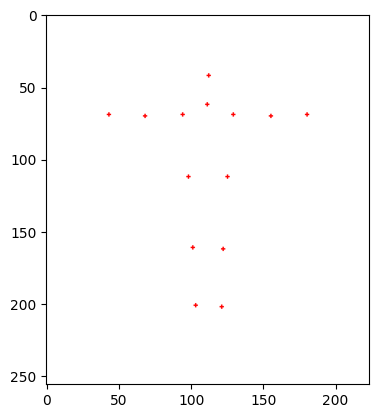

In [36]:
height, width = 256, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_bd = bg
alpha = 0.35  
out_img = draw_vetices(image_bd, J24_14_2d_joint, colors[0])
print(J24_14_2d_joint)
plt.imshow(out_img)

tensor([[ 0.1005,  0.7590],
        [ 0.0961,  0.3857],
        [ 0.1343, -0.0080],
        [-0.1293,  0.0052],
        [-0.1019,  0.4006],
        [-0.0857,  0.7676],
        [ 0.6007, -0.3815],
        [ 0.3760, -0.4029],
        [ 0.1299, -0.4082],
        [-0.1304, -0.4096],
        [-0.3746, -0.4100],
        [-0.6036, -0.3913],
        [-0.0026, -0.4403],
        [-0.0038, -0.6065]], device='cuda:0')


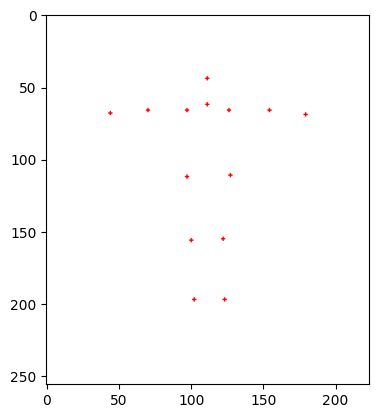

In [37]:
height, width = 256, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_bd = bg
alpha = 0.35  
out_img = draw_vetices(image_bd, J14_2d_joint, colors[0])
plt.imshow(out_img)
print(J14_2d_joint)

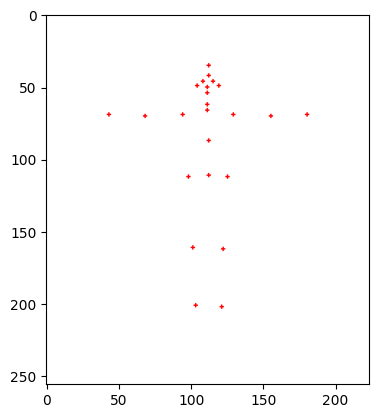

In [38]:
height, width = 256, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_bd = bg
alpha = 0.35  
out_img = draw_vetices(image_bd, J24_2d_joint, colors[0])
plt.imshow(out_img)

In [39]:
test_joints = torch.einsum('bik,ji->bjk', [smpl.v_template.unsqueeze(0), smpl.J_regressor])
# test_joints = h36m_joint
print(test_joints.shape)
pred_camera = torch.tensor([[0.9, 0, -0.2]])
test_2d_joint = orthographic_projection(test_joints.contiguous()*(-1), pred_camera.to(torch.device("cuda"))).squeeze()

torch.Size([1, 24, 3])


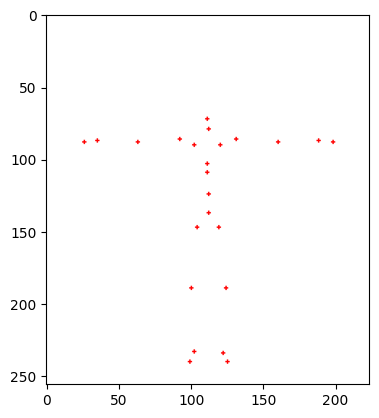

In [40]:
height, width = 256, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_bd = bg
out_img = draw_vetices(image_bd, test_joints[0]*(-1), colors[0])
plt.imshow(out_img)

torch.Size([14, 2])


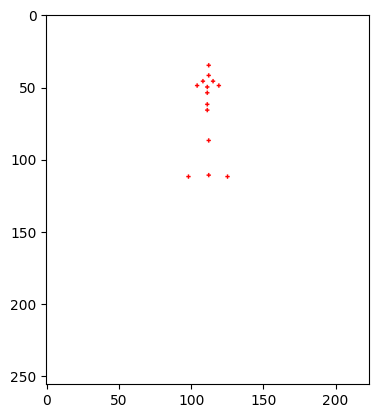

In [41]:
joints_extra = torch.einsum('bik,ji->bjk', [smpl.v_template.unsqueeze(0), smpl.J_regressor_extra])
extra_2d_joint = orthographic_projection(joints_extra.contiguous()*(-1), pred_camera.to(torch.device("cuda"))).squeeze()
print(extra_2d_joint.shape)
height, width = 256, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_bd = bg
out_img = draw_vetices(image_bd, extra_2d_joint, colors[0])
plt.imshow(out_img)

torch.Size([38, 2])


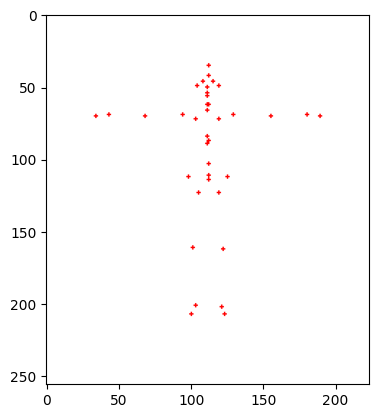

In [42]:
all_joints = torch.cat((test_joints, joints_extra), dim=1)
all_2d_joint = orthographic_projection(all_joints.contiguous()*(-1), pred_camera.to(torch.device("cuda"))).squeeze()
print(all_2d_joint.shape)
height, width = 256, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_bd = bg
out_img = draw_vetices(image_bd, all_2d_joint, colors[0])
plt.imshow(out_img)

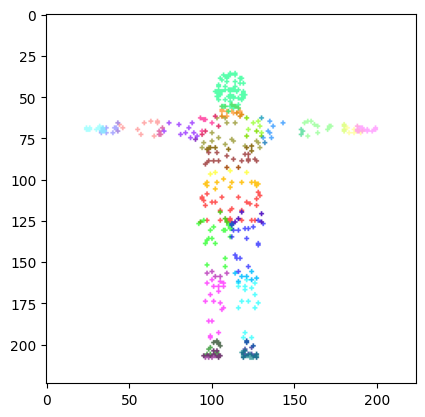

In [43]:
height, width = 224, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_bd = bg
alpha = 0.35  
for i in range(len(part)):
    out_img = draw_vetices(image_bd, part[i], colors[i])
    image_bd = cv2.addWeighted(image_bd, alpha, out_img, 1 - alpha, 0)
plt.imshow(image_bd)

In [44]:
from collections import Counter

all_values = [val for sublist in indices_lists for val in sublist ]
print(len(all_values))
counter = Counter(all_values)

# 找出出现次数大于 1 的张量，即为重复的张量
duplicates = [tensor for tensor, count in counter.items() if count > 1]
duplicates_pt = sub2_2d_mesh.index_select(0, torch.tensor(duplicates).to(torch.device("cuda")))
print("重复的张量有:", len(duplicates))


537
重复的张量有: 106


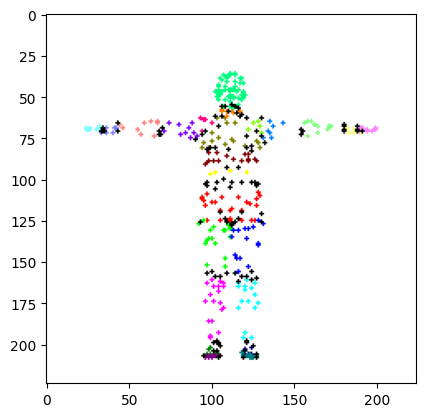

In [181]:
height, width = 224, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_bg = bg

for i in range(len(part)):
    image_bg = draw_vetices(image_bg, part[i], colors[i])
image_bg = draw_vetices(image_bg, duplicates_pt, (0,0,0))

plt.imshow(image_bg)

In [186]:
sub_weight.shape

torch.Size([431, 24])

In [194]:
import numpy as np

# 假设你有一个 431x24 的子权重矩阵
sub_weight = sub_weight.cpu()

# 初始化一个列表来存放每个顶点对应的影响最大的关节索引
max_influence_joints = [[] for _ in range(24)]
print(len(max_influence_joints))
# 遍历每个顶点
for vertex_idx in range(sub_weight.shape[0]):
    # 找到影响最大的关节索引
    max_joint_idx = np.argmax(sub_weight[vertex_idx])
    # 将索引放入列表中
    max_influence_joints[max_joint_idx].append(vertex_idx)

sum = 0 
# 打印結果
for i, non_indices_list in enumerate(max_influence_joints):
    print(f"Joint {i} indices with max weight : {non_indices_list}")
    sum += len(non_indices_list)
print("total number : ",sum)

24
Joint 0 indices with max weight : [45, 52, 53, 55, 56, 58, 59, 62, 63, 67, 69, 103, 118, 134, 135, 175, 188, 189, 190, 191, 192, 193, 266, 272, 273, 274, 277, 280, 284, 314, 344, 345, 346, 386, 387, 394, 395, 396, 397, 398]
Joint 1 indices with max weight : [57, 60, 61, 64, 65, 66, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 90, 93, 97, 100, 108, 109, 116, 117, 194, 195]
Joint 2 indices with max weight : [96, 275, 276, 279, 283, 286, 287, 288, 289, 290, 291, 292, 294, 295, 296, 297, 308, 309, 310, 311, 312, 325, 326, 327, 399]
Joint 3 indices with max weight : [95, 106, 171, 172, 182, 183, 184, 385]
Joint 4 indices with max weight : [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 94, 115, 197, 198, 199, 200, 201, 212, 228, 229]
Joint 5 indices with max weight : [293, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 322, 323, 324, 329, 400, 401, 402, 403, 413, 430]
Joint 6 indices with max weight : [39, 42, 43, 68, 101, 107, 111, 132, 173, 186, 187, 258, 261, 263, 264, 270, 278, 281, 2

In [197]:
all_values = [val for sublist in max_influence_joints for val in sublist ]
print(len(all_values))
counter = Counter(all_values)

# 找出出现次数大于 1 的张量，即为重复的张量
duplicates = [tensor for tensor, count in counter.items() if count > 1]
duplicates_pt = sub2_2d_mesh.index_select(0, torch.tensor(duplicates).to(torch.device("cuda")))
print("重复的张量有:", len(duplicates))

431
重复的张量有: 0


In [202]:
part_non_overlap = [sub2_2d_mesh.index_select(0, torch.tensor(sub_index).to(torch.device("cuda"))) for sub_index in max_influence_joints]

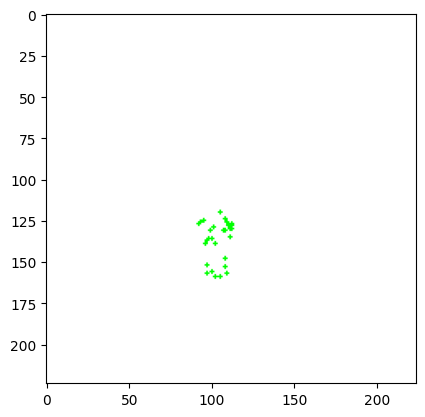

In [295]:
height, width = 224, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_nop = bg

# for i in range(len(part_non_overlap)):
#     # print(' part {}, color : {} '.format(i, colors[i]))
#     image_nop = draw_vetices(image_nop, part[i], colors[i])
i = 1
image_nop = draw_vetices(image_nop, part[i], colors[i])
plt.imshow(image_nop)

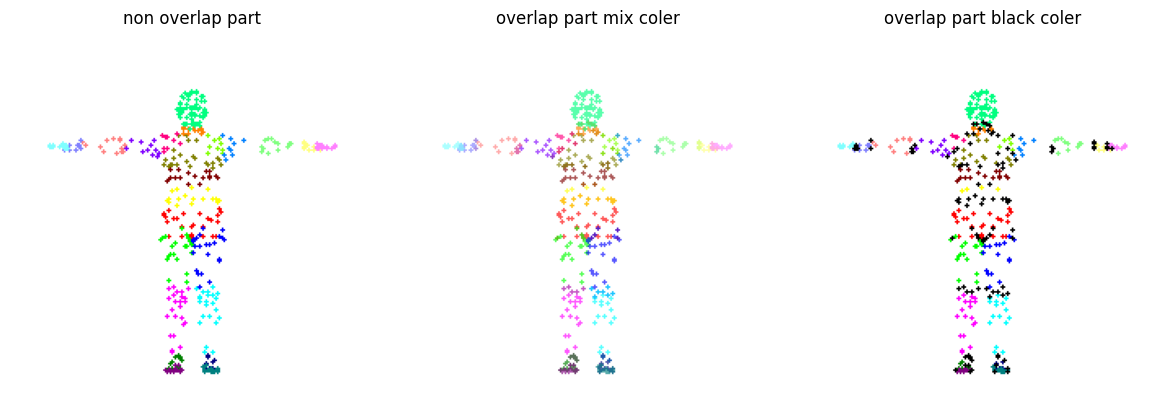

In [205]:
ig, axs = plt.subplots(1, 3, figsize=(12, 4))

# 在每个子图上显示一个图像
axs[0].imshow(image_nop)
axs[0].axis('off')  # 关闭坐标轴
axs[0].set_title('non overlap part')

axs[1].imshow(image_bd)
axs[1].axis('off')
axs[1].set_title('overlap part mix coler')

axs[2].imshow(image_bg)
axs[2].axis('off')
axs[2].set_title('overlap part black coler')

# 显示画布
plt.tight_layout()  # 调整子图布局，防止重叠
plt.show()

In [274]:
# ================================================= 14 Joint ======================================================
J24_TO_J14 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 18]
# J14_weight = smpl.weights[:,J24_TO_J14]
# J14_weight.shape

In [276]:
# ============================================ 14 Joint for 431 vertices ========================================
weight = smpl.weights
sub_weight = mesh_sampler.downsample(weight, n1=0, n2=2)
print(sub_weight.shape)
J14_sub_weight = sub_weight[:,J24_TO_J14]
print(J14_sub_weight.shape)

torch.Size([431, 24])
torch.Size([431, 14])


In [283]:
# ============================================ 找出頂點權重大於 0.33 的關節點 =========================================
# 創建一個空列表，用於存儲結果
indices_lists = [[] for _ in range(J14_sub_weight.shape[1])]

# 使用列表推導來填充每個列表
for joint_idx in range(J14_sub_weight.shape[1]):
    indices_lists[joint_idx] = (J14_sub_weight[:, joint_idx] > 0).nonzero().squeeze().tolist()

sum = 0 
# 打印結果
for i, indices_list in enumerate(indices_lists):
    # print(f"Joint {i} indices with weight > 0.33: {indices_list}")
    sum += len(indices_list)
print("total number : ",sum)

total number :  1130


In [284]:
J14_part = [sub2_2d_mesh.index_select(0, torch.tensor(sub_index).to(torch.device("cuda"))) for sub_index in indices_lists]
len(J14_part)

14

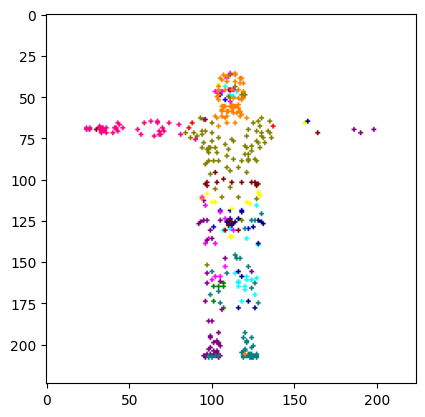

In [285]:
height, width = 224, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_J14 = bg

for i in range(len(J14_part)):
    # print(i)
    image_J14 = draw_vetices(image_J14, J14_part[i], colors[i])

plt.imshow(image_J14)

In [435]:
# get the 431 vertices and 14 joints
sub2_mesh = mesh_sampler.downsample(smpl.v_template, n1=0, n2=2)
H36M_J17_TO_J14 = [3, 2, 1, 4, 5, 6, 16, 15, 14, 11, 12, 13, 8, 10]
h36m_joint = smpl.get_h36m_joints(smpl.v_template.unsqueeze(0))
J14_joint = h36m_joint[:,H36M_J17_TO_J14,:].squeeze()
print(sub2_mesh.shape)
print(J14_joint.shape)

torch.Size([431, 3])
torch.Size([14, 3])


In [489]:
# =============================== 將 431 個頂點根據與 14 個關節點的距離進行分群。一個頂點可以在兩個關節的群 ===================
from scipy.spatial import distance_matrix
# 假设你有 431 个三维顶点和 14 个三维关节点
num_points = 431
num_joints = 14
num_dimensions = 3
threshold = 0.2  # 设置阈值

points = sub2_mesh.cpu()
joints = J14_joint.cpu()
# 计算每个顶点与每个关节点之间的距离
distances = distance_matrix(points, joints)

# 初始化一个列表，用于存放每个顶点所属的群组
clusters = [[] for _ in range(num_joints)]

# 将每个顶点分配到距离最近的关节点所在的群组中，如果距离小于阈值的最小距离的 10%，则也分配到该群组中
for i in range(num_points):
    min_distance_idx = np.argmin(distances[i])  # 找到距离最近的关节点的索引
    min_distance = distances[i, min_distance_idx]  # 最小距离
    for j in range(num_joints):
        if distances[i, j] <= min_distance * (1 + threshold):
            clusters[j].append(i)

# 打印每个群组中的顶点数量
for cluster_idx, cluster in enumerate(clusters):
    print(f"Cluster {cluster_idx}: {len(cluster)} points")
    # clusters 指出那是第幾個頂點

Cluster 0: 35 points
Cluster 1: 34 points
Cluster 2: 53 points
Cluster 3: 56 points
Cluster 4: 33 points
Cluster 5: 39 points
Cluster 6: 32 points
Cluster 7: 11 points
Cluster 8: 37 points
Cluster 9: 38 points
Cluster 10: 15 points
Cluster 11: 32 points
Cluster 12: 44 points
Cluster 13: 57 points


In [490]:
# ========================== 
sub2_2d_mesh = orthographic_projection(sub2_mesh.unsqueeze(0)*(-1), pred_camera.to(torch.device("cuda"))).squeeze()
J14_2d = orthographic_projection(J14_joint.unsqueeze(0)*(-1), pred_camera.to(torch.device("cuda"))).squeeze()
J14_part = [sub2_2d_mesh.index_select(0, torch.tensor(sub_index).to(torch.device("cuda"))) for sub_index in clusters]
print(J14_part[0].shape)

torch.Size([35, 2])


In [491]:
from collections import Counter

all_values = [val for sublist in clusters for val in sublist ]
print(len(all_values))
counter = Counter(all_values)

# 找出出现次数大于 1 的张量，即为重复的张量
duplicates = [tensor for tensor, count in counter.items() if count > 1]
duplicates_pt = sub2_2d_mesh.index_select(0, torch.tensor(duplicates).to(torch.device("cuda")))
print("重复的张量有:", len(duplicates))

516
重复的张量有: 65


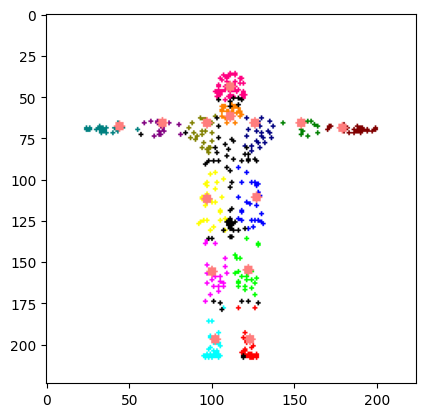

In [492]:
height, width = 224, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_J14 = bg

for i in range(len(J14_part)):
    image_J14 = draw_vetices(image_J14, J14_part[i], colors[i])
image_J14 = draw_vetices(image_J14, duplicates_pt, (0,0,0))
image_J14 = draw_vetices(image_J14, J14_2d, (255,125,125),r=3)
plt.imshow(image_J14)

In [494]:
device = torch.device("cuda")
adj_indices = torch.load('./src/modeling/data/smpl_431_adjmat_indices.pt')
adj_mat_value = torch.load('./src/modeling/data/smpl_431_adjmat_values.pt')
adj_mat_size = torch.load('./src/modeling/data/smpl_431_adjmat_size.pt')
adjmat = torch.sparse_coo_tensor(adj_indices, adj_mat_value, size=adj_mat_size).to(device)

In [503]:
import pandas as pd
blend_w_np = adjmat.to_dense().cpu().detach().numpy()
df = pd.DataFrame(blend_w_np)
df.to_csv('adjmat.csv', index=False)

In [556]:
import numpy as np
from scipy.spatial import distance_matrix

# 假设你有 431 个三维顶点和 14 个三维关节点
num_points = 431
num_joints = 14
num_dimensions = 3

# 生成随机的 431 个三维顶点和 14 个三维关节点作为示例数据
points = sub2_mesh.cpu()
joints = J14_joint.cpu()

# 计算每个顶点与每个关节点之间的距离
distances = distance_matrix(points, joints)

# 找到每个关节节点的最近顶点索引和对应的距离
nearest_points = []
for joint_idx in range(num_joints):
    nearest_point_idx = np.argmin(distances[:, joint_idx])  # 找到距离最近的顶点的索引
    nearest_distance = distances[nearest_point_idx, joint_idx]  # 最近顶点的距离
    nearest_points.append((nearest_point_idx, nearest_distance))

# 打印每个关节节点的最近顶点索引和对应的距离
for joint_idx, (point_idx, distance) in enumerate(nearest_points):
    print(f"Joint {joint_idx}: Nearest Point Index = {point_idx}, Distance = {distance}")


Joint 0: Nearest Point Index = 403, Distance = 0.028533199847607122
Joint 1: Nearest Point Index = 292, Distance = 0.06820441696400736
Joint 2: Nearest Point Index = 346, Distance = 0.02916239745653203
Joint 3: Nearest Point Index = 55, Distance = 0.035777471796607584
Joint 4: Nearest Point Index = 75, Distance = 0.04365983709437955
Joint 5: Nearest Point Index = 200, Distance = 0.021769461265400677
Joint 6: Nearest Point Index = 360, Distance = 0.024160429685253403
Joint 7: Nearest Point Index = 336, Distance = 0.04049016993548042
Joint 8: Nearest Point Index = 347, Distance = 0.04649401944890133
Joint 9: Nearest Point Index = 174, Distance = 0.03029429915118292
Joint 10: Nearest Point Index = 131, Distance = 0.03004576945234552
Joint 11: Nearest Point Index = 152, Distance = 0.017244359802807675
Joint 12: Nearest Point Index = 17, Distance = 0.049619153771656016
Joint 13: Nearest Point Index = 13, Distance = 0.07517796181215851


In [557]:
joint_nerest_v = [point_idx for joint_idx, (point_idx, distance) in enumerate(nearest_points)]
print(joint_nerest_v)

[403, 292, 346, 55, 75, 200, 360, 336, 347, 174, 131, 152, 17, 13]


In [735]:
import numpy as np
import networkx as nx

# 假设你有 431 个三维顶点和 14 个三维关节点
num_points = 431
num_joints = 14
num_dimensions = 3
threshold = 0.1

# 假设你有一个 431x431 的邻接矩阵，表示每个顶点之间的距离
# 请将你的邻接矩阵替换成实际的数据
adjacency_matrix = adjmat.to_dense().cpu().detach().numpy()
# adjacency_matrix = np.random.rand(num_points, num_points)

# 使用邻接矩阵创建一个带权重的图
G = nx.Graph()
for i in range(num_points):
    for j in range(num_points):
        if adjacency_matrix[i, j] != 0:
            # adjacency_matrix[i, j] = 1
            G.add_edge(i, j, weight=adjacency_matrix[i, j])

# 初始化一个列表，用于存放每个顶点距离最近的关节节点的距离和索引
nearest_joint_distances = []

J14_index_list = [[] for _ in range(num_joints)]
nodes = []
hyperedge_indices = []

# 计算每个顶点到所有关节节点的最短路径
for point_idx in range(num_points):
    shortest_paths = nx.single_source_dijkstra_path_length(G, point_idx)
    # 找到最短路径中到关节节点距离最小的那个顶点的距离和索引
    min_distance = float('inf')
    min_joint_idx = -1
    j_idx = -1
    for joint_idx in joint_nerest_v:
        j_idx += 1
        distance = shortest_paths.get(joint_idx, float('inf'))
        if distance < min_distance:
            min_distance = distance
            min_joint_idx = joint_idx
            min_j_idx = j_idx
    
    nearest_joint_distances.append((min_distance, min_joint_idx, min_j_idx))
    j_idx = -1
    for joint_idx in joint_nerest_v:
        j_idx += 1
        distance = shortest_paths.get(joint_idx, float('inf'))
        if distance <= min_distance*(1+threshold):
            J14_index_list[j_idx].append(point_idx)
            nodes.append(point_idx)
            hyperedge_indices.append(j_idx)
                
# 打印每个顶点距离最近的关节节点的距离和索引
for point_idx, (distance, joint_idx, min_j_idx) in enumerate(nearest_joint_distances):
    print(f"Point {point_idx}: Nearest Joint Distance = {distance}, Nearest vertex Index = {joint_idx}, Nearest joint Index = {min_j_idx}")



Point 0: Nearest Joint Distance = 0.2678571492433548, Nearest vertex Index = 13, Nearest joint Index = 13
Point 1: Nearest Joint Distance = 0.32500000298023224, Nearest vertex Index = 13, Nearest joint Index = 13
Point 2: Nearest Joint Distance = 0.32500000298023224, Nearest vertex Index = 13, Nearest joint Index = 13
Point 3: Nearest Joint Distance = 0.125, Nearest vertex Index = 13, Nearest joint Index = 13
Point 4: Nearest Joint Distance = 0.4583333432674408, Nearest vertex Index = 13, Nearest joint Index = 13
Point 5: Nearest Joint Distance = 0.125, Nearest vertex Index = 13, Nearest joint Index = 13
Point 6: Nearest Joint Distance = 0.30000000447034836, Nearest vertex Index = 17, Nearest joint Index = 12
Point 7: Nearest Joint Distance = 0.34285715222358704, Nearest vertex Index = 17, Nearest joint Index = 12
Point 8: Nearest Joint Distance = 0.125, Nearest vertex Index = 13, Nearest joint Index = 13
Point 9: Nearest Joint Distance = 0.125, Nearest vertex Index = 13, Nearest joint

In [588]:
from collections import Counter

all_values = [val for sublist in J14_index_list for val in sublist ]
print(len(all_values))
counter = Counter(all_values)

# 找出出现次数大于 1 的张量，即为重复的张量
duplicates = [tensor for tensor, count in counter.items() if count > 1]
duplicates_pt = sub2_2d_mesh.index_select(0, torch.tensor(duplicates).to(torch.device("cuda")))
print("重复的张量有:", len(duplicates))

504
重复的张量有: 61


In [22]:
nearest_pt = [sub2_2d_mesh.index_select(0, torch.tensor(sub_index).to(torch.device("cuda"))) for sub_index in J14_index_list]
nearest_14j_v = sub2_2d_mesh.index_select(0, torch.tensor(joint_nerest_v).to(torch.device("cuda")))

In [23]:
joint_nerest_v

[403, 292, 346, 55, 75, 200, 360, 336, 347, 174, 131, 152, 17, 13]

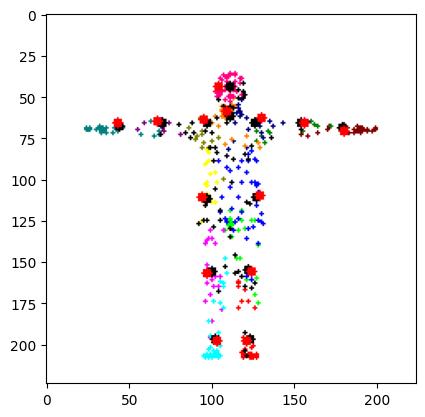

In [591]:
height, width = 224, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_J14 = bg

for i in range(len(J14_part)):
    image_J14 = draw_vetices(image_J14, nearest_pt[i], colors[i])
image_J14 = draw_vetices(image_J14, duplicates_pt, (0,0,0))
image_J14 = draw_vetices(image_J14, J14_2d, (0,0,0),r=3)
image_J14 = draw_vetices(image_J14, nearest_14j_v, (255,0,0),r=3)
plt.imshow(image_J14)

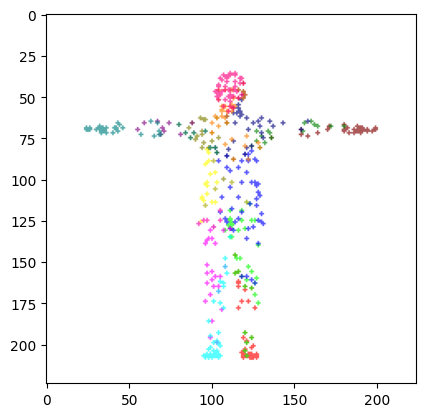

In [592]:
height, width = 224, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_bd = bg
alpha = 0.35  
for i in range(len(nearest_pt)):
    out_img = draw_vetices(image_bd, nearest_pt[i], colors[i])
    image_bd = cv2.addWeighted(image_bd, alpha, out_img, 1 - alpha, 0)
plt.imshow(image_bd)

In [593]:
from itertools import chain
import numpy as np
e_list = J14_index_list
v_idx = list(chain(* e_list))
e_idx = [[idx] * len(e) for idx, e in enumerate(e_list)]
e_idx = list(chain(*e_idx))
print(len(e_idx))
H = np.zeros((num_v, len(e_list)))
print(len(v_idx))

504
504


In [594]:
num_v=431
hg = Hypergraph(num_v, J14_index_list)

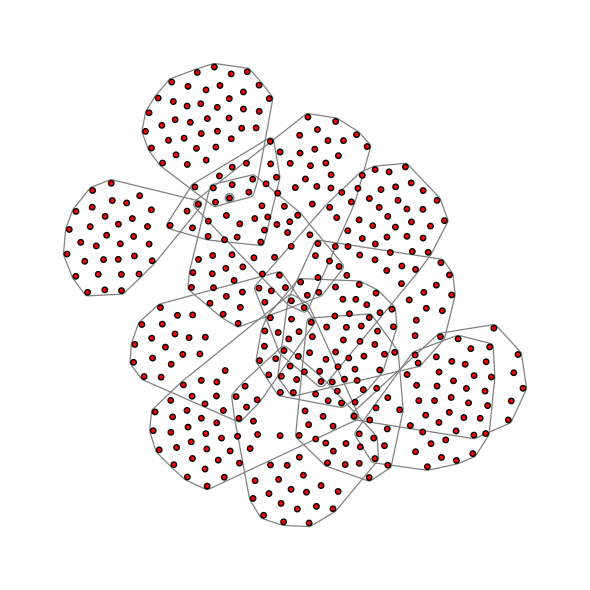

In [595]:
hg.draw()

In [602]:
hg.save("mesh_graph_distance_hg.pkl")

In [601]:
hg.num_e

14

In [603]:
l_hg = Hypergraph.load("mesh_graph_distance_hg.pkl")

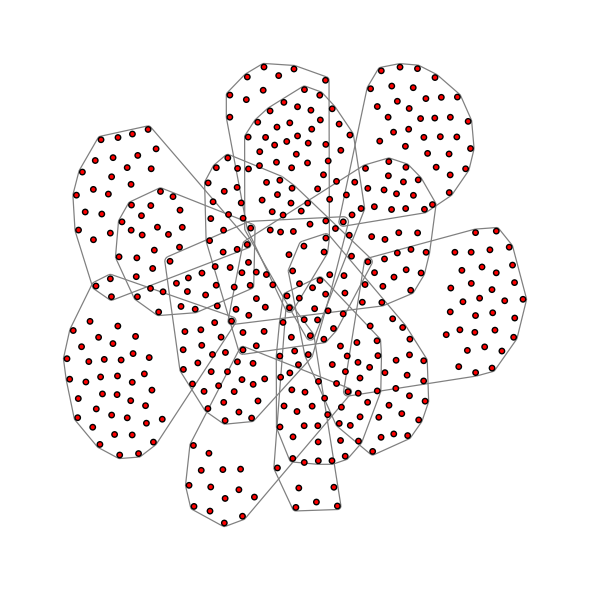

In [606]:
l_hg.draw()

In [633]:
from dhg.models.hypergraphs.hypergcn import HyperGCN
from dhg.models.hypergraphs.hnhn import HNHN
X = torch.rand(1, num_v, 128)
in_channels = 128
hid_channels = 384
HyperGCN = HNHN(in_channels = in_channels, hid_channels = hid_channels, num_classes = num_v)
y = HyperGCN(X, l_hg)

RuntimeError: The expanded size of the tensor (431) must match the existing size (384) at non-singleton dimension 1.  Target sizes: [14, 431].  Tensor sizes: [14, 384]

In [661]:
P = l_hg.H_T
P = P.unsqueeze(0)
X = X.permute(0,2,1)
# X = torch.sparse.mm(P, X)

In [662]:
print(P.shape) # batch, m, n
print(X.shape) # batch, m, p

torch.Size([1, 14, 431])
torch.Size([1, 431, 128])


In [663]:
result = torch.sparse.mm(P.view(-1, P.size(-2), P.size(-1)),
                          X.view(-1, X.size(-2), X.size(-1)))
result = result.view(sp_mat.size(0), sp_mat.size(1), dense_mat.size(2))
print(result.shape)  # 输出为 (batch_size, m, p)

NotImplementedError: Could not run 'aten::view' with arguments from the 'SparseCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::view' is only available for these backends: [CPU, CUDA, Meta, QuantizedCPU, QuantizedCUDA, MkldnnCPU, NestedTensorCPU, NestedTensorCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at aten/src/ATen/RegisterCPU.cpp:31188 [kernel]
CUDA: registered at aten/src/ATen/RegisterCUDA.cpp:44143 [kernel]
Meta: registered at aten/src/ATen/RegisterMeta.cpp:26829 [kernel]
QuantizedCPU: registered at aten/src/ATen/RegisterQuantizedCPU.cpp:944 [kernel]
QuantizedCUDA: registered at aten/src/ATen/RegisterQuantizedCUDA.cpp:459 [kernel]
MkldnnCPU: registered at aten/src/ATen/RegisterMkldnnCPU.cpp:515 [kernel]
NestedTensorCPU: registered at aten/src/ATen/RegisterNestedTensorCPU.cpp:703 [kernel]
NestedTensorCUDA: registered at aten/src/ATen/RegisterNestedTensorCUDA.cpp:835 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at aten/src/ATen/RegisterFunctionalization_3.cpp:24446 [kernel]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: fallthrough registered at ../aten/src/ATen/ConjugateFallback.cpp:21 [kernel]
Negative: fallthrough registered at ../aten/src/ATen/native/NegateFallback.cpp:23 [kernel]
ZeroTensor: registered at aten/src/ATen/RegisterZeroTensor.cpp:161 [kernel]
ADInplaceOrView: registered at ../torch/csrc/autograd/generated/ADInplaceOrViewType_1.cpp:5074 [kernel]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradHIP: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradMPS: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradIPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradVE: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradMTIA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradMeta: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18233 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:18212 [kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_3.cpp:14610 [kernel]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:382 [backend fallback]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:249 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/BatchRulesViews.cpp:565 [kernel]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1079 [kernel]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:157 [backend fallback]


In [631]:
import torch

# 假设你有一个形状为 [14, 384] 的张量 tensor
tensor = torch.randn(14, 384)

# 扩展张量的尺寸，增加一个维度，并在新维度上填充相同的值
expanded_tensor = tensor.unsqueeze(1).expand(-1, 431, -1)

# 检查扩展后的张量的尺寸
print(expanded_tensor.size())

torch.Size([14, 431, 384])


In [667]:
import torch

from torch_geometric.nn import HypergraphConv

In [752]:
import torch

from torch_geometric.nn import HypergraphConv


in_channels, out_channels = (16, 32)
hyperedge_index = torch.tensor([[0, 0, 1, 1, 2, 3], [0, 1, 0, 1, 0, 1]])
num_nodes = hyperedge_index[0].max().item() + 1
num_edges = hyperedge_index[1].max().item() + 1
batch_size = 4
x = torch.randn((batch_size, num_nodes, in_channels))
hyperedge_weight = torch.tensor([1.0, 0.5])
hyperedge_attr = torch.randn((num_edges, in_channels))

conv = HypergraphConv(in_channels, out_channels)
# conv = HypergraphConv(in_channels, out_channels, use_attention=True,heads=2)
assert str(conv) == 'HypergraphConv(16, 32)'
# print(x.shape)
output = []
for i in range(x.shape[0]):
    out = conv(x[i], hyperedge_index, hyperedge_attr=hyperedge_attr)
    output.append(out)
out = torch.stack(output, dim=0)
# assert out.size() == (num_nodes, out_channels)
# out = conv(x, hyperedge_index, hyperedge_weight)
# assert out.size() == (num_nodes, out_channels)

# conv = HypergraphConv(in_channels, out_channels, use_attention=True,
#                       heads=2, node_dim=1)
# out = conv(x, hyperedge_index, hyperedge_attr=hyperedge_attr)
# assert out.size() == (num_nodes, 2 * out_channels)
# out = conv(x, hyperedge_index, hyperedge_weight, hyperedge_attr)
# assert out.size() == (num_nodes, 2 * out_channels)

# conv = HypergraphConv(in_channels, out_channels, use_attention=True,
#                       heads=2, concat=False, dropout=0.5, node_dim=1)
# out = conv(x, hyperedge_index, hyperedge_weight, hyperedge_attr)
# print(out.shape)
# assert out.size() == (num_nodes, out_channels)

In [753]:
x.shape

torch.Size([4, 4, 16])

In [754]:
hyperedge_attr.shape

torch.Size([2, 16])

In [720]:
nodes = []
hyperedge_indices = []

for i, hyperedge in enumerate(l_hg.e):
    for node in hyperedge:
        nodes.append(node)
        hyperedge_indices.append(i)

In [730]:
len(nodes)
len(hyperedge_indices)

504

In [10]:
# ============================================ pytorch geometric =================================

In [1]:
import torch
device = torch.device("cuda")
adj_indices = torch.load('./src/modeling/data/smpl_431_adjmat_indices.pt')
adj_mat_value = torch.load('./src/modeling/data/smpl_431_adjmat_values.pt')
adj_mat_size = torch.load('./src/modeling/data/smpl_431_adjmat_size.pt')
adjmat = torch.sparse_coo_tensor(adj_indices, adj_mat_value, size=adj_mat_size).to(device)

In [2]:
from src.modeling._smpl import SMPL, Mesh
smpl = SMPL().to(torch.device('cuda'))
mesh_sampler = Mesh()

/home/juno/MambaHMR/src/modeling/_smpl.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  i = torch.LongTensor([row, col])
/home/juno/MambaHMR/src/modeling/_smpl.py:43: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  self.register_buffer('J_regressor', torch.sparse.FloatTensor(i, v, J_regressor_shape).to_dense())
/home/juno/anaconda3/envs/hgcn/lib/python3.9/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [44]:
# get the 431 vertices and 14 joints
sub2_mesh = mesh_sampler.downsample(smpl.v_template, n1=0, n2=2)
H36M_J17_TO_J14 = [3, 2, 1, 4, 5, 6, 16, 15, 14, 11, 12, 13, 8, 10]
h36m_joint = smpl.get_h36m_joints(smpl.v_template.unsqueeze(0))
J14_joint = h36m_joint[:,H36M_J17_TO_J14,:].squeeze()
print(sub2_mesh.shape)
print(J14_joint.shape)

torch.Size([431, 3])
torch.Size([14, 3])


In [4]:
import numpy as np
from scipy.spatial import distance_matrix

# 假设你有 431 个三维顶点和 14 个三维关节点
num_points = 431
num_joints = 14
num_dimensions = 3

# 生成随机的 431 个三维顶点和 14 个三维关节点作为示例数据
points = sub2_mesh.cpu()
joints = J14_joint.cpu()

# 计算每个顶点与每个关节点之间的距离
distances = distance_matrix(points, joints)

# 找到每个关节节点的最近顶点索引和对应的距离
nearest_points = []
for joint_idx in range(num_joints):
    nearest_point_idx = np.argmin(distances[:, joint_idx])  # 找到距离最近的顶点的索引
    nearest_distance = distances[nearest_point_idx, joint_idx]  # 最近顶点的距离
    nearest_points.append((nearest_point_idx, nearest_distance))

# 打印每个关节节点的最近顶点索引和对应的距离
for joint_idx, (point_idx, distance) in enumerate(nearest_points):
    print(f"Joint {joint_idx}: Nearest Point Index = {point_idx}, Distance = {distance}")

joint_nerest_v = [point_idx for joint_idx, (point_idx, distance) in enumerate(nearest_points)]

Joint 0: Nearest Point Index = 403, Distance = 0.028533199847607122
Joint 1: Nearest Point Index = 292, Distance = 0.06820441696400736
Joint 2: Nearest Point Index = 346, Distance = 0.02916239745653203
Joint 3: Nearest Point Index = 55, Distance = 0.035777471796607584
Joint 4: Nearest Point Index = 75, Distance = 0.04365983709437955
Joint 5: Nearest Point Index = 200, Distance = 0.021769461265400677
Joint 6: Nearest Point Index = 360, Distance = 0.024160429685253403
Joint 7: Nearest Point Index = 336, Distance = 0.04049016993548042
Joint 8: Nearest Point Index = 347, Distance = 0.04649401944890133
Joint 9: Nearest Point Index = 174, Distance = 0.03029429915118292
Joint 10: Nearest Point Index = 131, Distance = 0.03004576945234552
Joint 11: Nearest Point Index = 152, Distance = 0.017244359802807675
Joint 12: Nearest Point Index = 17, Distance = 0.049619153771656016
Joint 13: Nearest Point Index = 13, Distance = 0.07517796181215851


In [5]:
joint_nerest_v

[403, 292, 346, 55, 75, 200, 360, 336, 347, 174, 131, 152, 17, 13]

In [24]:
from src.utils.geometric_layers import orthographic_projection
pred_camera = torch.tensor([[0.9, 0, -0.2]])
sub2_mesh = mesh_sampler.downsample(smpl.v_template, n1=0, n2=2)
sub2_2d_mesh = orthographic_projection(sub2_mesh.unsqueeze(0)*(-1), pred_camera.to(torch.device("cuda"))).squeeze()
nearest_14j_v = sub2_2d_mesh.index_select(0, torch.tensor(joint_nerest_v).to(torch.device("cuda")))

In [79]:
def draw_vetices(background, vertices_2d, color, r = 1, bone=None):
    image = background.copy() 
    vertices_norm = ((vertices_2d + 1) * 0.5) * image.shape[1]
    for jj in range(vertices_2d.shape[0]):
        x = int(vertices_norm[jj,0])
        y = int(vertices_norm[jj,1])
        cv2.putText(image , str(jj), (x+5,y+5), cv2.FONT_HERSHEY_PLAIN,  1, color, 1, cv2.LINE_AA)
        cv2.circle(image,(x,y), r, color, -1) 
    if bone != None:
        for (i, j) in bone:
            xi = int(vertices_norm[i,0])
            yi = int(vertices_norm[i,1])
            xj = int(vertices_norm[j,0])
            yj = int(vertices_norm[j,1])
            cv2.line(image, (xi,yi), (xj,yj), (0,0,0))
    
    return image

In [80]:
# edge_index = torch.tensor([
#     [0, 1, 2, 3, 4, 3, 9, 9, 10, 12 ],  # 起点
#     [1, 2, 8, 4, 5, 9, 10, 12, 11, 13]   # 终点
# ], dtype=torch.long)
node = 13

edges = [(0,1),(1,2),(2,12),(3,4),(4,5),(3,12),(9,10),(9,12),(10,11),(12,13), (12,8), (8,7), (7,6) ]
edge_index = torch.tensor(edges + [(j, i) for i, j in edges] + [(i, i) for i in range(node)] , dtype=torch.long).t().contiguous()

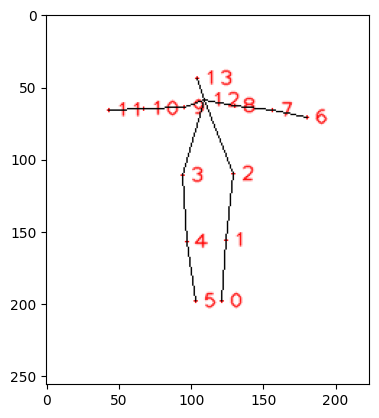

In [81]:
from PIL import Image
from src.utils.renderer import Renderer
import cv2
import matplotlib
# matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
height, width = 256, 224
bg = np.ones((height, width, 3), dtype=np.uint8) * 255
image_bd = bg
alpha = 0.35  
out_img = draw_vetices(image_bd, nearest_14j_v, (255,0,0), bone=edges)
plt.imshow(out_img)
# print(J14_2d_joint)

In [82]:

# 查看邻接矩阵
adj_matrix = to_dense_adj(edge_index)
print("Adjacency Matrix:\n", adj_matrix.squeeze().numpy())

Adjacency Matrix:
 [[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [83]:
torch.save(edge_index, 'tensor_14joint_graph.pt')

In [6]:
n = 292
if n in joint_nerest_v:
    print(len(joint_nerest_v))

14


In [7]:
import numpy as np
import networkx as nx

# 假设你有 431 个三维顶点和 14 个三维关节点
num_points = 431
num_joints = 14
num_dimensions = 3
threshold = 0.1

# 假设你有一个 431x431 的邻接矩阵，表示每个顶点之间的距离
# 请将你的邻接矩阵替换成实际的数据
adjacency_matrix = adjmat.to_dense().cpu().detach().numpy()
# adjacency_matrix = np.random.rand(num_points, num_points)

# 使用邻接矩阵创建一个带权重的图
G = nx.Graph()
for i in range(num_points):
    for j in range(num_points):
        if adjacency_matrix[i, j] != 0:
            # adjacency_matrix[i, j] = 1
            G.add_edge(i, j, weight=adjacency_matrix[i, j])

# 初始化一个列表，用于存放每个顶点距离最近的关节节点的距离和索引
nearest_joint_distances = []

J14_index_list = [[] for _ in range(num_joints)]
nodes = []
hyperedge_indices = []

# 计算每个顶点到所有关节节点的最短路径
for point_idx in range(num_points):
    shortest_paths = nx.single_source_dijkstra_path_length(G, point_idx)
    # 找到最短路径中到关节节点距离最小的那个顶点的距离和索引
    min_distance = float('inf')
    min_joint_idx = -1
    j_idx = -1
    for joint_idx in joint_nerest_v:
        j_idx += 1
        distance = shortest_paths.get(joint_idx, float('inf'))
        if distance < min_distance:
            min_distance = distance
            min_joint_idx = joint_idx
            min_j_idx = j_idx

    # 創建第 15 個 hyperedge，將 14 個代理關節點放進去
    if point_idx in joint_nerest_v:
        nodes.append(point_idx)
        hyperedge_indices.append(len(joint_nerest_v))
    
    # nodes.append(point_idx)
    # hyperedge_indices.append(min_j_idx)
    nearest_joint_distances.append((min_distance, min_joint_idx, min_j_idx))
    j_idx = -1
    for joint_idx in joint_nerest_v:
        j_idx += 1
        distance = shortest_paths.get(joint_idx, float('inf'))
        if distance <= min_distance*(1+threshold):
            J14_index_list[j_idx].append(point_idx)
            nodes.append(point_idx)
            hyperedge_indices.append(j_idx)
                
# 打印每个顶点距离最近的关节节点的距离和索引
for point_idx, (distance, joint_idx, min_j_idx) in enumerate(nearest_joint_distances):
    print(f"Point {point_idx}: Nearest Joint Distance = {distance}, Nearest vertex Index = {joint_idx}, Nearest joint Index = {min_j_idx}")


Point 0: Nearest Joint Distance = 0.2678571492433548, Nearest vertex Index = 13, Nearest joint Index = 13
Point 1: Nearest Joint Distance = 0.32500000298023224, Nearest vertex Index = 13, Nearest joint Index = 13
Point 2: Nearest Joint Distance = 0.32500000298023224, Nearest vertex Index = 13, Nearest joint Index = 13
Point 3: Nearest Joint Distance = 0.125, Nearest vertex Index = 13, Nearest joint Index = 13
Point 4: Nearest Joint Distance = 0.4583333432674408, Nearest vertex Index = 13, Nearest joint Index = 13
Point 5: Nearest Joint Distance = 0.125, Nearest vertex Index = 13, Nearest joint Index = 13
Point 6: Nearest Joint Distance = 0.30000000447034836, Nearest vertex Index = 17, Nearest joint Index = 12
Point 7: Nearest Joint Distance = 0.34285715222358704, Nearest vertex Index = 17, Nearest joint Index = 12
Point 8: Nearest Joint Distance = 0.125, Nearest vertex Index = 13, Nearest joint Index = 13
Point 9: Nearest Joint Distance = 0.125, Nearest vertex Index = 13, Nearest joint

In [11]:
joint_nerest_v

[403, 292, 346, 55, 75, 200, 360, 336, 347, 174, 131, 152, 17, 13]

In [8]:
hyperedge_index = torch.tensor([nodes,hyperedge_indices])

In [60]:
import torch
from torch_geometric.data import Data
from torch_geometric.data.batch import Batch
from src.modeling.data.Hypergraph_batch import HG_Batch

edge_index_s = torch.tensor([
    [0, 0, 0, 0],
    [1, 2, 3, 4],
])
x_s = torch.randn(5, 16)  # 5 nodes.
edge_index_t = torch.tensor([
    [0, 0, 0],
    [1, 2, 3],
])
x_t = torch.randn(4, 16)  # 4 nodes.

edge_index_3 = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x_3 = torch.randn(4, 16)

data1= Data(x=x_s,edge_index=hyperedge_index)
data2= Data(x=x_t,edge_index=edge_index_t)
data3= Data(x=x_3,edge_index=edge_index_3)
#上面是构建3张Data图对象
# * `Batch(Data)` in case `Data` objects are batched together
#* `Batch(HeteroData)` in case `HeteroData` objects are batched together

data_list = [data1, data2,data3]


loader = Batch.from_data_list(data_list)#调用该函数data_list里的data1、data2、data3 三张图形成一张大图，也就是batch
print('data_list:\n',data_list)
#data_list: [Data(edge_index=[2, 4], x=[5, 16]), Data(edge_index=[2, 3], x=[4, 16]), Data(edge_index=[2, 4], x=[4, 16])]
print('batch:',loader.batch)
#batch: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])
print('loader:',loader)
#loader: Batch(batch=[13], edge_index=[2, 11], x=[13, 16])
print('loader.edge_index:\n',loader.edge_index) #batch的边的元组
#loader.edge_index:
#tensor([[ 0,  0,  0,  0,  5,  5,  5,  9, 10, 10, 11],
#        [ 1,  2,  3,  4,  6,  7,  8, 10,  9, 11, 10]])

print('loader.num_graphs:',loader.num_graphs)#该batch的图的个数，这里是3个
#loader.num_graphs: 3

Batch=Batch.to_data_list(loader)#大图Batch变回成3张小图
print(Batch)


data_list:
 [Data(x=[5, 16], edge_index=[2, 518]), Data(x=[4, 16], edge_index=[2, 3]), Data(x=[4, 16], edge_index=[2, 4])]
batch: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])
loader: DataBatch(x=[13, 16], edge_index=[2, 525], batch=[13], ptr=[4])
loader.edge_index:
 tensor([[ 0,  1,  2,  ..., 10, 10, 11],
        [13, 13, 13,  ...,  9, 11, 10]])
loader.num_graphs: 3
[Data(x=[5, 16], edge_index=[2, 518]), Data(x=[4, 16], edge_index=[2, 3]), Data(x=[4, 16], edge_index=[2, 4])]


In [13]:
hyperedge_index[1]

tensor([13, 13, 13, 13, 13, 13, 12, 13, 12, 13, 13, 12, 13, 12, 14, 13, 12,  8,
        12, 13, 14, 12, 13, 13, 13, 13, 12, 12, 13, 12, 13, 12, 13, 13, 13, 12,
        13, 13, 12, 13, 13, 13, 12, 13, 13, 13,  2,  3,  8,  9, 11,  9, 11,  3,
         3,  2,  3,  9,  2,  3,  9, 12,  9, 12,  9, 11,  9, 11,  3,  3, 12, 14,
         3,  3,  4,  3,  2,  3,  4,  2,  3,  4,  3,  1,  4,  4,  2,  2,  3,  4,
         4,  1,  5,  5,  4, 14,  4,  5,  4,  4,  4,  4,  4,  5,  5,  4,  5,  5,
         5,  4,  4,  5,  4,  5,  5,  4,  4,  4,  3,  1,  3,  4,  9, 12, 10,  3,
         3,  9,  2, 12,  9, 12,  2,  2,  8,  1,  1,  9, 11,  3,  8,  9, 12,  9,
         9, 10,  5,  3,  4,  2,  3,  4,  1, 11, 11, 10, 11, 11, 11, 10, 10, 10,
        10, 11, 10, 11, 14, 10,  3, 13,  3,  2, 12,  9,  9,  9, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 14, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 13,  3,  2,  8, 14,  9,  2, 12,
         9,  9,  9,  9,  9,  9,  2,  3, 

In [61]:
hyperedge_index[0].shape

torch.Size([518])

In [62]:
torch.save(hyperedge_index, 'tensor_hg_overlap_joint_hg.pt')

In [11]:
import torch

from torch_geometric.nn import HypergraphConv
import torch
from torch_geometric.data import Data
from torch_geometric.data.batch import Batch
from src.modeling.data.Hypergraph_batch import HG_Batch

in_channels, out_channels = (16, 32)
hyperedge_index = torch.tensor([[0, 0, 1, 1, 2, 3], [0, 1, 0, 1, 0, 1]])
num_nodes = hyperedge_index[0].max().item() + 1 # 4
num_edges = hyperedge_index[1].max().item() + 1 # 2
batch_size = 4
x = torch.randn((batch_size, num_nodes, in_channels))
hyperedge_weight = torch.tensor([1.0, 0.5])
hyperedge_attr = torch.randn((batch_size, num_edges, out_channels))

conv = HypergraphConv(in_channels, out_channels)
# conv = HypergraphConv(in_channels, out_channels, use_attention=True,heads=2)
assert str(conv) == 'HypergraphConv(16, 32)'
# print(x.shape)
output = []
for i in range(x.shape[0]):
    out = conv(x[i], hyperedge_index, hyperedge_attr=hyperedge_attr)
    output.append(out)
out = torch.stack(output, dim=0)

In [75]:
class HGCN_GB(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, num_layers=10):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        # self.convs.append(HypergraphConv(in_channels, hidden_channels))
        # for _ in range(num_layers - 2):
        #     self.convs.append(HypergraphConv(hidden_channels, hidden_channels))
        #     # self.convs.append(HypergraphConv(hidden_channels, hidden_channels, use_attention=True, concat=False, heads=2, dropout=0.5))
        # self.convs.append(HypergraphConv(hidden_channels, out_channels))
        self.convs.append(HypergraphConv(in_channels, out_channels))

    def forward(self, x, hyperedge_index, hyperedge_attr):
        B, N, C =x.shape
        # print(hyperedge_attr.shape)
        data = [Data(x=x[i], edge_index=hyperedge_index, edge_attr=hyperedge_attr[i]) for i in range(x.shape[0])]
        batch_data = HG_Batch.from_data_list(data)
        # for conv in self.convs:
        output = batch_data.x
        print("batch_data_x : ", batch_data.x)
        print("batch_data_edge_index : ", batch_data.edge_index)
        print("batch_data_hyperedge_attr : ", batch_data.edge_attr)
        for i, conv in enumerate(self.convs):
            output = conv(output, batch_data.edge_index, hyperedge_attr=batch_data.edge_attr)

        
        output = output.view(B, N, -1)

        return output

In [86]:
class HGCN_S(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, num_layers=10):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        # self.convs.append(HypergraphConv(in_channels, hidden_channels))
        # for _ in range(num_layers - 2):
        #     self.convs.append(HypergraphConv(hidden_channels, hidden_channels))
        #     # self.convs.append(HypergraphConv(hidden_channels, hidden_channels, use_attention=True, concat=False, heads=2, dropout=0.5))
        # self.convs.append(HypergraphConv(hidden_channels, out_channels))
        # self.conv1  = HypergraphConv(in_channels, hidden_channels)
        # self.conv2  = HypergraphConv(hidden_channels, hidden_channels)
        # self.conv3  = HypergraphConv(hidden_channels, hidden_channels, use_attention=True, concat=True, heads=2, dropout=0.5)
        # self.conv4  = HypergraphConv(hidden_channels, out_channels)
        self.convs.append(HypergraphConv(in_channels, out_channels))

    def forward(self, x, hyperedge_index, hyperedge_attr):
        out = []
        for i in range(x.shape[0]):
            x_i = x[i]
            print("single_data_x : ", x_i)
            print("single_data_edge_index : ", hyperedge_index)
            print("single_data_hyperedge_attr : ", hyperedge_attr[i])
            for conv in self.convs:
                x_i = conv(x_i, hyperedge_index, hyperedge_attr=hyperedge_attr[i])
            out.append(x_i)
            print(f"out {i} : {x_i}")
        output = torch.stack(out, dim=0)

        return output

In [87]:
import random
import torch
import numpy as np
def set_seed(seed=42, loader=None):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True        
    try:
        loader.sampler.generator.manual_seed(seed)
    except AttributeError:
        pass

In [92]:
import torch
import random
import numpy as np

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

In [93]:
set_seed()

In [137]:
model_dim=(8,16)
batch_size = 4
in_channels, out_channels = (model_dim[0], model_dim[1])
hyperedge_index = torch.tensor([[0, 0, 1, 1, 2, 3], [0, 1, 0, 1, 0, 1]])
x = torch.randn((batch_size, num_nodes, in_channels))
hyperedge_attr = torch.randn((batch_size, num_edges, out_channels))
hgcn_gb = HGCN_GB(in_channels = model_dim[0], out_channels = model_dim[1], hidden_channels= model_dim[1], num_layers=3)
hgcn_s = HGCN_S(in_channels = model_dim[0], out_channels = model_dim[1], hidden_channels= model_dim[1], num_layers=3)
conv = HypergraphConv(in_channels, out_channels)

In [138]:
from time import time
# print("x input :", x)
# print("hyperedge_attr :", hyperedge_attr)
B, N, C =x.shape
data = [Data(x=x[i], edge_index=hyperedge_index, edge_attr=hyperedge_attr[i]) for i in range(x.shape[0])]
batch_data = HG_Batch.from_data_list(data)
start = time()
v_features_gb = conv(batch_data.x, batch_data.edge_index)
v_features_gb = v_features_gb.view(B, N, -1)
end = time()
print(f"batch time : {end-start}")
print("batch output :", v_features_gb)

batch time : 0.0007929801940917969
batch output : tensor([[[ 0.2109, -0.2529,  0.0390,  0.4932,  0.1857, -0.2918, -0.0259,
           0.2148,  0.0459, -0.1659,  0.2987, -0.4424,  0.3493,  0.1911,
           0.4417,  0.1992],
         [ 0.2109, -0.2529,  0.0390,  0.4932,  0.1857, -0.2918, -0.0259,
           0.2148,  0.0459, -0.1659,  0.2987, -0.4424,  0.3493,  0.1911,
           0.4417,  0.1992],
         [ 0.0105, -0.0040,  0.3787,  0.4613, -0.0769, -0.4717, -0.3492,
           0.4923,  0.6249, -0.7165,  0.6199, -0.5497,  0.4037, -0.2329,
           0.5061, -0.0493],
         [ 0.4113, -0.5018, -0.3008,  0.5250,  0.4482, -0.1119,  0.2974,
          -0.0627, -0.5331,  0.3846, -0.0225, -0.3351,  0.2949,  0.6151,
           0.3774,  0.4477]],

        [[-0.3031,  0.1673, -0.3972, -0.0355, -0.2707,  0.1720, -0.0396,
           0.2818, -0.2995,  0.6024,  0.1857, -0.2293,  0.6723,  0.2529,
          -0.8576, -0.2835],
         [-0.3031,  0.1673, -0.3972, -0.0355, -0.2707,  0.1720, -0.0396,


In [139]:
v_features_gb.shape

torch.Size([4, 4, 16])

In [140]:
from time import time
# print("x input :", x)
# print("hyperedge_attr :", hyperedge_attr)
start = time()
# v_features_s = conv(x[0], hyperedge_index).transpose(0, 1)
out = []
for i in range(x.shape[0]):
    x_i = x[i]
    x_i = conv(x_i, hyperedge_index, hyperedge_attr=hyperedge_attr[i])
    out.append(x_i)
    # print(f"out {i} : {x_i}")
v_features_s = torch.stack(out, dim=0)
end = time()
print(f"batch single time : {end-start}")
print("batch singel output :", v_features_s)

batch single time : 0.0026922225952148438
batch singel output : tensor([[[ 0.2109, -0.2529,  0.0390,  0.4932,  0.1857, -0.2918, -0.0259,
           0.2148,  0.0459, -0.1659,  0.2987, -0.4424,  0.3493,  0.1911,
           0.4417,  0.1992],
         [ 0.2109, -0.2529,  0.0390,  0.4932,  0.1857, -0.2918, -0.0259,
           0.2148,  0.0459, -0.1659,  0.2987, -0.4424,  0.3493,  0.1911,
           0.4417,  0.1992],
         [ 0.0105, -0.0040,  0.3787,  0.4613, -0.0769, -0.4717, -0.3492,
           0.4923,  0.6249, -0.7165,  0.6199, -0.5497,  0.4037, -0.2329,
           0.5061, -0.0493],
         [ 0.4113, -0.5018, -0.3008,  0.5250,  0.4482, -0.1119,  0.2974,
          -0.0627, -0.5331,  0.3846, -0.0225, -0.3351,  0.2949,  0.6151,
           0.3774,  0.4477]],

        [[-0.3031,  0.1673, -0.3972, -0.0355, -0.2707,  0.1720, -0.0396,
           0.2818, -0.2995,  0.6024,  0.1857, -0.2293,  0.6723,  0.2529,
          -0.8576, -0.2835],
         [-0.3031,  0.1673, -0.3972, -0.0355, -0.2707,  0.1

In [133]:
x.shape

torch.Size([2, 4, 8])

In [130]:
v_features_s.shape

torch.Size([2, 4, 16])

In [97]:
from time import time
# print("x input :", x)
# print("hyperedge_attr :", hyperedge_attr)
start = time()
v_features_ss = hgcn_s(x, hyperedge_index, hyperedge_attr).transpose(0, 1)
end = time()
print(f"batch single time : {end-start}")
print("batch singel output :", v_features_ss)

single_data_x :  tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047],
        [-0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624],
        [ 1.6423, -0.1596, -0.4974,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806],
        [ 1.2791,  1.2964,  0.6105,  1.3347, -0.2316,  0.0418, -0.2516,  0.8599]])
single_data_edge_index :  tensor([[0, 0, 1, 1, 2, 3],
        [0, 1, 0, 1, 0, 1]])
single_data_hyperedge_attr :  tensor([[-1.3847, -0.8712, -0.2234,  1.7174,  0.3189, -0.4245,  0.3057, -0.7746,
         -1.5576,  0.9956, -0.8798, -0.6011, -1.2742,  2.1228, -1.2347, -0.4879],
        [-0.9138, -0.6581,  0.0780,  0.5258, -0.4880,  1.1914, -0.8140, -0.7360,
         -1.4032,  0.0360, -0.0635,  0.6756, -0.0978,  1.8446, -1.1845,  1.3835]])
out 0 : tensor([[ 3.2228e-01,  5.9533e-01, -2.9194e-01,  2.0842e-01,  6.8010e-04,
          8.6312e-01,  1.0578e+00,  7.7720e-01,  1.5208e-02,  1.4429e-01,
          1.7392e-01, -7.0303e-01,  2.3951e-01,  4.0757e-0

In [261]:
from time import time
# print("x input :", x)
# print("hyperedge_attr :", hyperedge_attr)
start = time()
v_features_gb = hgcn_gb(x, hyperedge_index, hyperedge_attr).transpose(0, 1)
end = time()
print(f"batch time : {end-start}")
print("batch output :", v_features_gb)

torch.Size([32, 2, 16])


IndexError: index 126 is out of bounds for dimension 0 with size 64

In [232]:
hyperedge_index[1]

tensor([0, 1, 0, 1, 0, 1])

In [160]:
hyperedge_attr[0].shape

torch.Size([2, 4])

In [277]:
model_dim=(8,16)
batch_size = 2
in_channels, out_channels = (model_dim[0], model_dim[1])
hyperedge_index = torch.tensor([[0, 0, 1, 1, 2, 3], [0, 1, 0, 1, 0, 1]])
x = torch.randn((batch_size, num_nodes, in_channels))
hyperedge_attr = torch.randn((batch_size, num_edges, out_channels))

In [301]:
data[0].edge_index

tensor([[0, 0, 1, 1, 2, 3],
        [0, 1, 0, 1, 0, 1]])

In [302]:
data[1].edge_index

tensor([[0, 0, 1, 1, 2, 3],
        [0, 1, 0, 1, 0, 1]])

In [303]:
batch_data.edge_index

tensor([[0, 0, 1, 1, 2, 3, 4, 4, 5, 5, 6, 7],
        [0, 1, 0, 1, 0, 1, 4, 5, 4, 5, 4, 5]])

In [316]:
values = [data[0].edge_index, data[1].edge_index]

In [304]:
hyperedge_index[0]

tensor([0, 0, 1, 1, 2, 3])

In [306]:
hg_incs = torch.tensor([[0,0],[431,14]])

In [325]:
tensor_list = [torch.stack((value[0] + hg_inc[0], value[1] + hg_inc[1])) for value, hg_inc in zip(values, hg_incs)]

In [322]:
tensor_list

[[tensor([0, 0, 1, 1, 2, 3]), tensor([0, 1, 0, 1, 0, 1])],
 [tensor([431, 431, 432, 432, 433, 434]), tensor([14, 15, 14, 15, 14, 15])]]

In [340]:
x = torch.tensor([431, 431])
y = torch.tensor([14, 14])
result_x = cumsum(x, dim=0)
result_y = cumsum(y, dim=0)
result = torch.stack([result_x, result_y], dim=1)
print(result_x)
print(result_y)
print(result)

tensor([  0, 431, 862])
tensor([ 0, 14, 28])
tensor([[  0,   0],
        [431,  14],
        [862,  28]])


In [343]:
tensor_list = [torch.stack((value[0] + hg_inc[0], value[1] + hg_inc[1])) for value, hg_inc in zip(values, result)]

In [41]:
import os.path as op
from src.datasets.human_mesh_tsv import MeshTSVYamlDataset
yaml_file = "/home/juno/datasets/Tax-H36m-coco40k-Muco-UP-Mpii/train.yaml"
is_train = True
scale_factor = 1
train_dataloader = MeshTSVYamlDataset(yaml_file, is_train, False, scale_factor)


In [74]:
(img_keys, images, annotations) = train_dataloader[1]

In [85]:
gt_pose = annotations['pose'].cuda()
gt_betas = annotations['betas'].cuda()
gt_vertices = smpl(gt_pose.unsqueeze(0), gt_betas.unsqueeze(0))

In [101]:
for i in range(1,2):
    print(1)

1


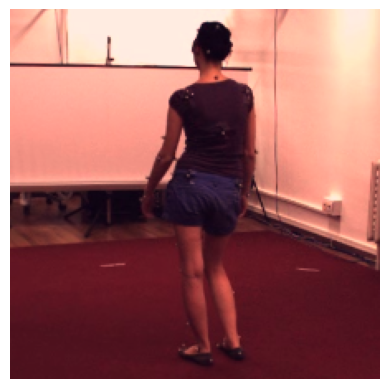

In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 將 PyTorch 張量轉換為 NumPy 陣列
img_np = images.numpy()
min_val = img_np.min()
max_val = img_np.max()
img_np = (img_np - min_val) / (max_val - min_val)

# 轉換顏色通道從 (3, 224, 224) 到 (224, 224, 3)
img_np = np.transpose(img_np, (1, 2, 0))
img_np_bgr = img_np[:, :, ::]
# 顯示圖片
plt.imshow(img_np_bgr)
plt.axis('off')  # 隱藏坐標軸
plt.show()

In [98]:
pred_camera = torch.tensor([[1, 0.2, 0.2]])
gt_2d_vertices = orthographic_projection(gt_vertices, pred_camera.cuda()).squeeze()

Text(0.5, 1.0, 'full vertices : 6890')

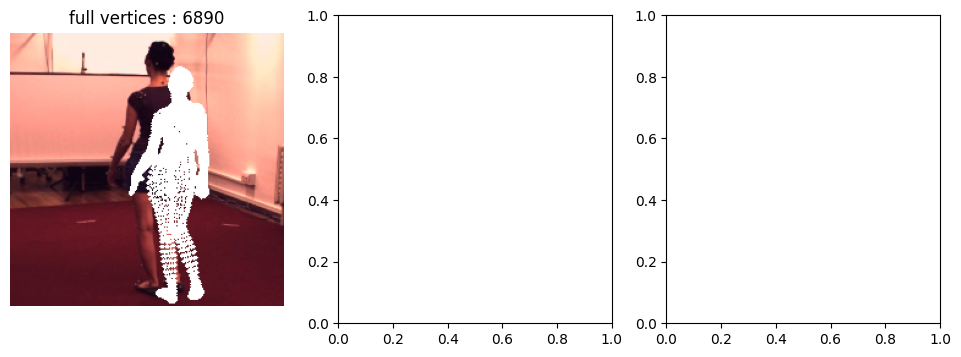

In [99]:
height, width = 224, 224
background = np.zeros((height, width, 3), dtype=np.uint8)
color = (255,255,255)
image1 = draw_vetices(img_np_bgr, gt_2d_vertices, color)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# 在每个子图上显示一个图像
axs[0].imshow(image1)
axs[0].axis('off')  # 关闭坐标轴
axs[0].set_title('full vertices : 6890')